In [61]:
import cv2
import csv

lines = []
images = []
tl_indices = []
distances = []
states = []

with open("TrafficLight_sim/state.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

for line in lines:
    #image = cv2.imread("TrafficLight_sim/data000000.png")
    index = int(line[0])
    tl_indices.append(int(line[1]))
    distances.append(float(line[2]))
    state = int(line[3])
    if state == 4:
        state = 3
    states.append(state)
    image = cv2.imread("TrafficLight_sim/data{:06d}.png".format(index))             
    images.append(image)
    
print("Done...")

Done...


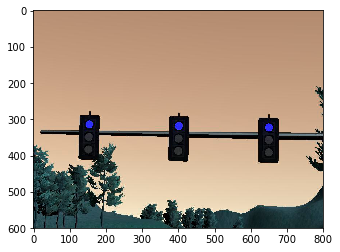

Image Index=0, TL index=0, distance=41.0748367008, state=0
Image shape=(600, 800, 3)


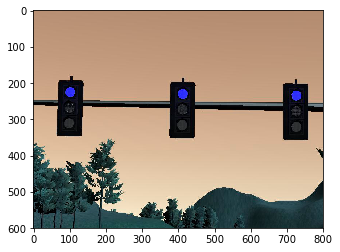

Image Index=20, TL index=1, distance=402.189706793, state=3
Image shape=(600, 800, 3)


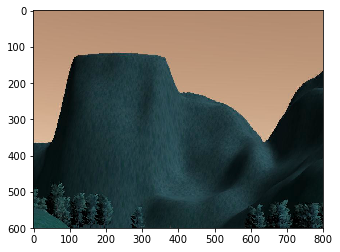

Image Index=40, TL index=1, distance=297.752582163, state=3
Image shape=(600, 800, 3)


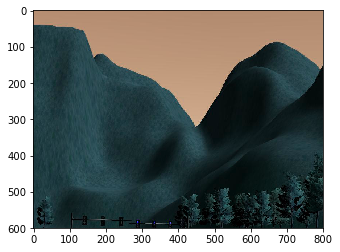

Image Index=60, TL index=1, distance=193.623931292, state=0
Image shape=(600, 800, 3)


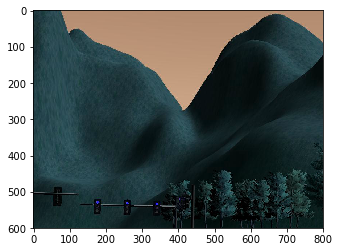

Image Index=80, TL index=1, distance=83.8268378087, state=0
Image shape=(600, 800, 3)


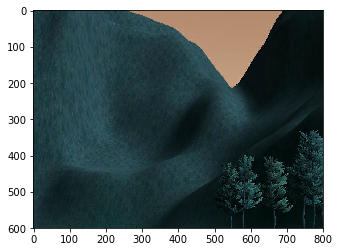

Image Index=100, TL index=2, distance=655.899249618, state=3
Image shape=(600, 800, 3)


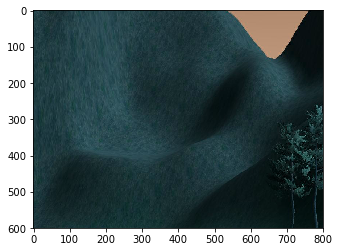

Image Index=120, TL index=2, distance=584.48826437, state=3
Image shape=(600, 800, 3)


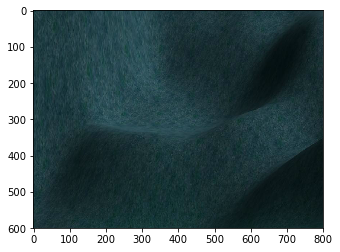

Image Index=140, TL index=2, distance=522.50407858, state=3
Image shape=(600, 800, 3)


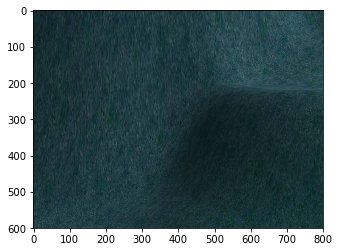

Image Index=160, TL index=2, distance=451.212490511, state=3
Image shape=(600, 800, 3)


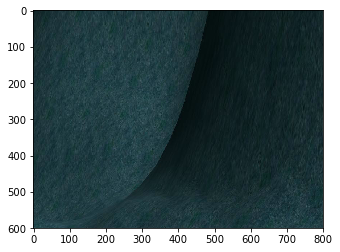

Image Index=180, TL index=2, distance=375.448883286, state=3
Image shape=(600, 800, 3)


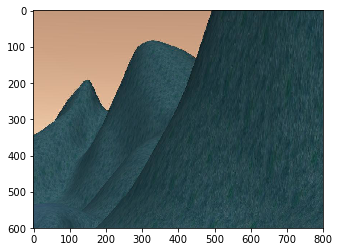

Image Index=200, TL index=2, distance=271.736614964, state=3
Image shape=(600, 800, 3)


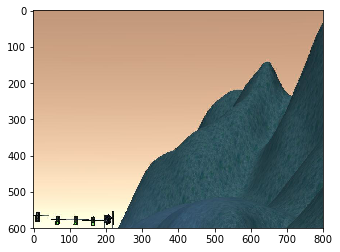

Image Index=220, TL index=2, distance=169.412122884, state=0
Image shape=(600, 800, 3)


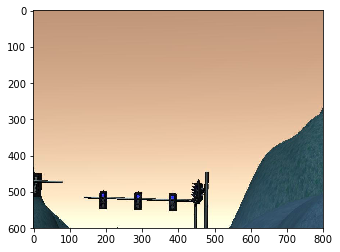

Image Index=240, TL index=2, distance=67.7421287236, state=0
Image shape=(600, 800, 3)


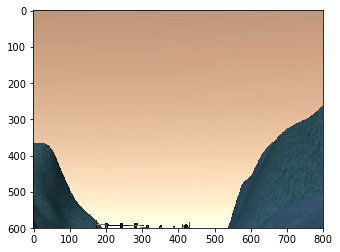

Image Index=260, TL index=3, distance=239.488804264, state=3
Image shape=(600, 800, 3)


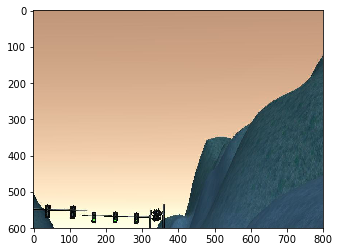

Image Index=280, TL index=3, distance=136.025637205, state=0
Image shape=(600, 800, 3)


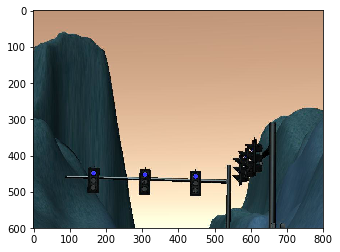

Image Index=300, TL index=3, distance=32.3192842897, state=0
Image shape=(600, 800, 3)


In [62]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

for i in range(0, len(images), 20):
    plt.imshow(images[i], cmap='brg')
    plt.show()
    #print("Index={}, State={}".format(i, states[i]))
    print("Image Index={}, TL index={}, distance={}, state={}".format(i, tl_indices[i], distances[i], states[i]))
    print("Image shape={}".format(images[i].shape))

In [63]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

onehot_encoder = OneHotEncoder(sparse=False)
states_2d = np.array(states)
states_2d = states_2d.reshape(-1, 1)

#print(states_2d)
states_onehot = onehot_encoder.fit_transform(states_2d)
print("Shape of Onehot encoded array {}".format(states_onehot.shape))
print(states_onehot)

Shape of Onehot encoded array (309, 4)
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


In [64]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images_train, images_test, states_train, states_test = train_test_split(
    images, states_onehot, test_size=0.2, random_state=11)

print("Number of images total: {}, states total: {}".format(len(images), len(states)))
print("Number of images train: {}, states train: {}".format(len(images_train), len(states_train)))
print("Number of images test : {}, states test : {}".format(len(images_test), len(states_test)))

Number of images total: 309, states total: 309
Number of images train: 247, states train: 247
Number of images test : 62, states test : 62


In [71]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
# Normalize
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(600, 800, 3)))

model.add(Conv2D(filters=6,
                        kernel_size=5,
                        strides=5,
                        activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(180, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(4))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_13 (Lambda)           (None, 600, 800, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 120, 160, 6)       456       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 60, 80, 6)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 76, 16)        2416      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 38, 16)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 28, 38, 16)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 17024)             0         
__________

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu")`
  app.launch_new_instance()


In [75]:
images_arr = np.array(images)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
hist = model.fit(images_arr, states_onehot, batch_size=10, epochs=10, validation_split=0.2)

Train on 247 samples, validate on 62 samples
Epoch 1/10
247/247 [==============================] - 11s - loss: 0.0473 - acc: 0.9150 - val_loss: 0.0905 - val_acc: 0.7419
Epoch 2/10
247/247 [==============================] - 11s - loss: 0.0309 - acc: 0.9352 - val_loss: 0.0876 - val_acc: 0.7258
Epoch 3/10
247/247 [==============================] - 12s - loss: 0.0276 - acc: 0.9433 - val_loss: 0.0978 - val_acc: 0.7097
Epoch 4/10
247/247 [==============================] - 12s - loss: 0.0247 - acc: 0.9636 - val_loss: 0.0981 - val_acc: 0.7258
Epoch 5/10
247/247 [==============================] - 12s - loss: 0.0206 - acc: 0.9798 - val_loss: 0.0968 - val_acc: 0.7258
Epoch 6/10
247/247 [==============================] - 11s - loss: 0.0180 - acc: 0.9919 - val_loss: 0.1024 - val_acc: 0.6613
Epoch 7/10
247/247 [==============================] - 12s - loss: 0.0150 - acc: 0.9879 - val_loss: 0.0955 - val_acc: 0.7258
Epoch 8/10
247/247 [==============================] - 11s - loss: 0.0134 - acc: 0.9960 